<a href="https://colab.research.google.com/github/YarinBou/Data-Streaming-Algorithms-and-Online-Learning/blob/main/count-min-count-min-sketch-with-morris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Streaming Algorithms and Online Learning EX2

Yarin Bouzaglo
Enav sasson

In [ ]:
!pip install mmh3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U -q PyDrive

In [ ]:
from google.colab import drive
import pandas as pd
import random
from tabulate import tabulate
from collections import Counter,defaultdict
from tqdm import tqdm
import math
import numpy as np
import random
import os
import random
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import mmh3
import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm import tqdm

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1IoAt94Hcwoc-oe2gKlz4lvz9IUk-ZVFT/view"

# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('xclara.csv') 
 
df = pd.read_csv('xclara.csv')

In [ ]:
df.head()

,time,ipv4Src,ipv4Dest,ipProtocol,volume,sourcePort,destPort
0,2017-07-03 11:55:58.598307848,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
1,2017-07-03 11:55:58.598311901,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
2,2017-07-03 11:55:58.598312855,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
3,2017-07-03 11:55:58.598313808,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
4,2017-07-03 11:55:58.598314762,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0


## count-min-sketch

In [ ]:
ipv4Src_ls = df.ipv4Src.values.tolist()
ipv4Src_unique = df.ipv4Src.unique().tolist()

In [ ]:
class CountMinSketchWithMorris:
  """
  Args:
            d (int): number of hash functions
            w (int): size of hash 
            s (int): size of morris array 
  """
  def __init__(self,d,w,s):
    if d <= 0 or w <= 0 or s <= 1:
      raise ValueError("d, w, s must be greater than 0, s must be greater than 1.")
    self.d = d
    self.w = w
    self.s = s

    self.p = 100000 # a (relatively) large prime

    self.a = [random.randrange(self.p) for i in range(d)]
    self.b = [random.randrange(self.p) for i in range(d)]

    self.array_init()

  def morris_array_init(self):
      return [0 for x in range(self.s)] 

  def array_init(self):
      self.array = [[self.morris_array_init() for x in range(self.w)] for y in range(self.d)] 
  
  def hash(self, x, a, b):
      return ((a*mmh3.hash(x)+b)%self.p)%self.w

  def get_hashes(self, x):
      hashes = []
      for a, b in zip(self.a, self.b):
          hashes.append(self.hash(x, a, b))
      return hashes

  def update(self, x, show=False):
    hashes = self.get_hashes(x)
    for i, h in enumerate(hashes):
      for j in range(self.s):
        self.array[i][h][j] = self.update_morris(self.array[i][h][j])
    if show:
        print(self)
  
  def update_morris(self,counter):
      if random.random() <= 2**(-counter):
        return counter + 1
      return counter

  def mean_morris_arr(self,arr):
    return np.mean(arr)

  def query(self, x):
    hashes = self.get_hashes(x)
    counts = [self.mean_morris_arr(self.array[i][h]) for i, h in enumerate(hashes)]
    output = [(2**x) - 1 for x in counts]
    return min(output)

In [ ]:
size = len(df.ipv4Src)
#size = 1000000

In [ ]:
ipv4Src_ls_size = df.ipv4Src.values.tolist()[0:size]
ipv4Src_unique_size = list(set(ipv4Src_ls_size))
len(ipv4Src_unique_size)

9640

In [ ]:
counter_morris = CountMinSketchWithMorris(20, 500000,3) 

for x in tqdm(ipv4Src_ls_size):
    counter_morris.update(x)

100%|██████████| 11625503/11625503 [13:37<00:00, 14226.79it/s]


In [ ]:
value_count_dict = df.ipv4Src.head(size).value_counts().to_dict()

In [ ]:
def evaluate_MSE(true_dict,sketch,size):
    mse = []
    for key in true_dict:
        count = sketch.query(key)
        mse.append((true_dict[key]-count)**2)
    loss = sum(mse)/size
    return loss

In [ ]:
loss_morris = evaluate_MSE(value_count_dict,counter_morris,size)
print(loss_morris)

357111.11942724744


In [ ]:
pred_dict = {}
for x in ipv4Src_unique_size:
  pred_dict[x] = counter_morris.query(x)

In [ ]:
N = 10
res_pred = dict(sorted(pred_dict.items(), key = itemgetter(1), reverse = True)[:N])
res_true = dict(sorted(value_count_dict.items(), key = itemgetter(1), reverse = True)[:N])


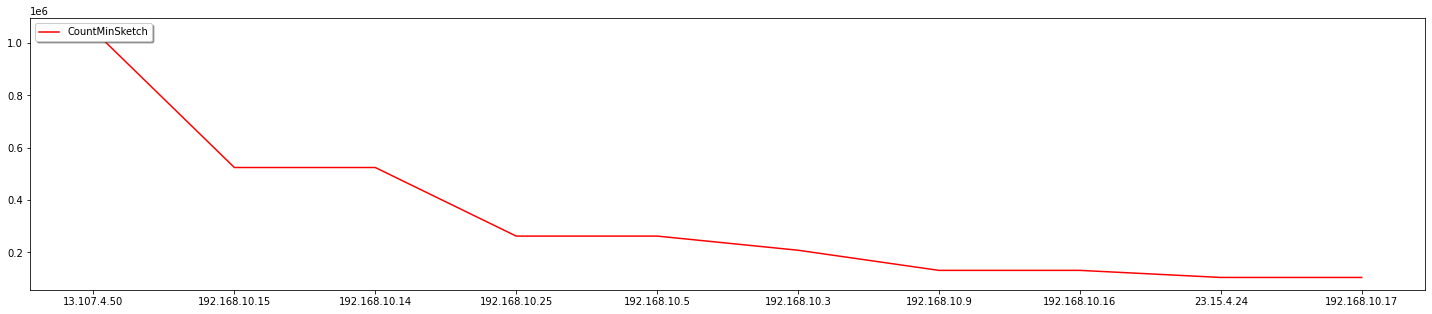

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(list(res_pred.keys()), list(res_pred.values()),'r',label='CountMinSketch')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

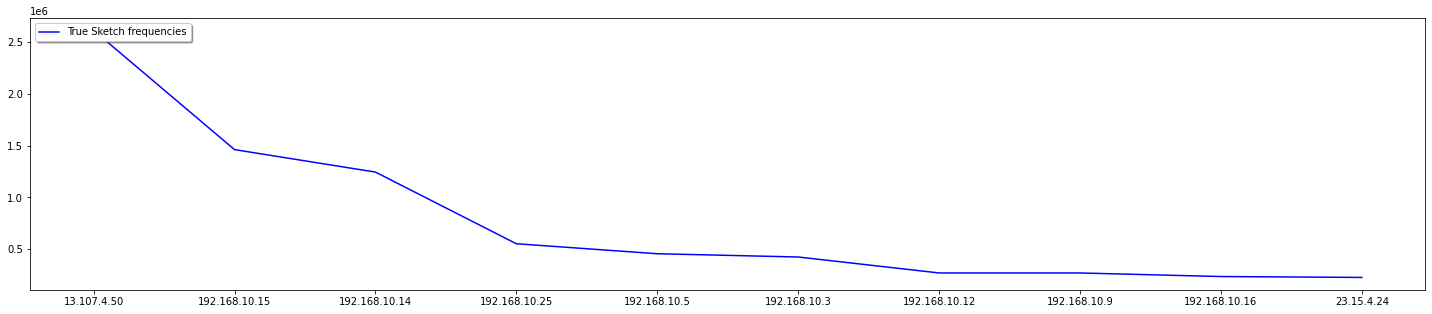

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(list(res_true.keys()), list(res_true.values()),'b',label='True Sketch frequencies')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

## count-sketch

In [ ]:
class CountSketchWithMorris:
  """
  Args:
            d (int): number of hash functions
            w (int): size of hash 
  """
  def __init__(self,d,w):
    if d <= 0 or w <= 0:
      raise ValueError("d, w, s must be greater than 0, s must be greater than 1.")
    self.d = d
    self.w = w
    self.s = 2

    self.p = 100000 # a (relatively) large prime

    self.a = [random.randrange(self.p) for i in range(d)]
    self.b = [random.randrange(self.p) for i in range(d)]

    self.array_init()

  def morris_array_init(self):
      return [0 for x in range(self.s)] 

  def array_init(self):
      self.array = [[self.morris_array_init() for x in range(self.w)] for y in range(self.d)] 
  
  def sign_hash(self, x, a, b):
      return 1 if (a*mmh3.hash(x) + b) % 2 == 0 else -1

  def hash(self, x, a, b):
      return ((a*mmh3.hash(x)+b)%self.p)%self.w

  def get_hashes(self, x):
      hashes = []
      for a, b in zip(self.a, self.b):
          hashes.append(self.hash(x, a, b))
      return hashes
    
  def get_sign_hashes(self, x):
    sign_hashes = []
    for a, b in zip(self.a, self.b):
        sign_hashes.append(self.sign_hash(x, a, b))
    return sign_hashes

  def update(self, x, show=False):
    hashes = self.get_hashes(x)
    sign_hashes = self.get_sign_hashes(x)
    for i, h in enumerate(hashes):
      if sign_hashes[i] > 0:
        # o contain the positive counter
        self.array[i][h][0] = self.update_morris(self.array[i][h][0])
      else:
        # 1 countain the negative counter
        self.array[i][h][1] = self.update_morris(self.array[i][h][1])
    if show:
        print(self)
  
  def update_morris(self,counter):
      if random.random() <= 2**(-counter):
        return counter + 1
      return counter

  def sum_up_subArr(self, x):
    hashes = self.get_hashes(x)
    sign_hashes = self.get_sign_hashes(x)
    counts = []
    for i, h in enumerate(hashes):
      counts.append(sign_hashes[i]* (self.array[i][h][0] - self.array[i][h][1]))
    return counts

    output = [(2**x) - 1 for x in counts]

  def query(self, x):
    hashes = self.get_hashes(x)
    counts = self.sum_up_subArr(x)
    output = [(2**x) - 1 for x in counts]
    return np.median(output)

In [ ]:
counterSketch = CountSketchWithMorris(20, 500000) 
for x in tqdm(ipv4Src_ls_size):
    counterSketch.update(x)

100%|██████████| 11625503/11625503 [09:50<00:00, 19691.24it/s]


In [ ]:
pred_counterSketch_dict = {}
for x in ipv4Src_unique_size:
  pred_counterSketch_dict[x] = counterSketch.query(x)

In [ ]:
N = 10
res_pred_counterSketch = dict(sorted(pred_counterSketch_dict.items(), key = itemgetter(1), reverse = True)[:N])
res_true_counterSketch = dict(sorted(value_count_dict.items(), key = itemgetter(1), reverse = True)[:N])


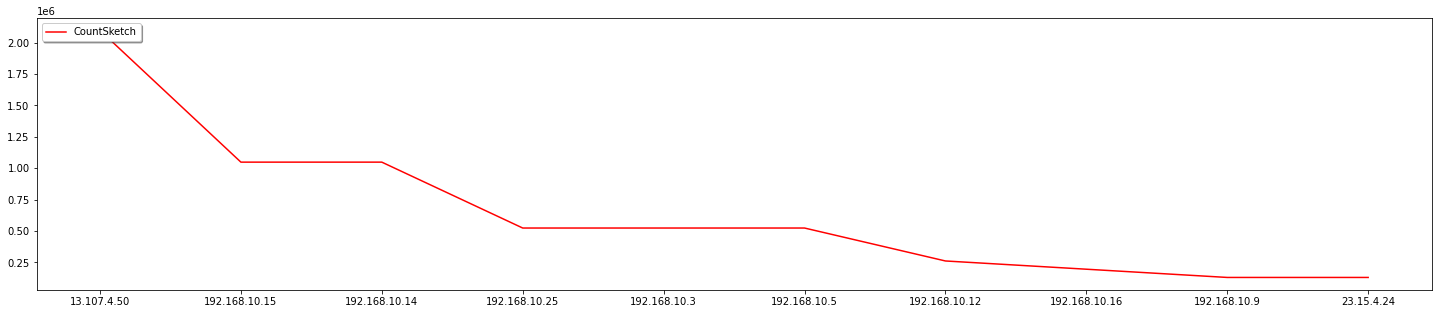

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(list(res_pred_counterSketch.keys()), list(res_pred_counterSketch.values()),'r',label='CountSketch')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

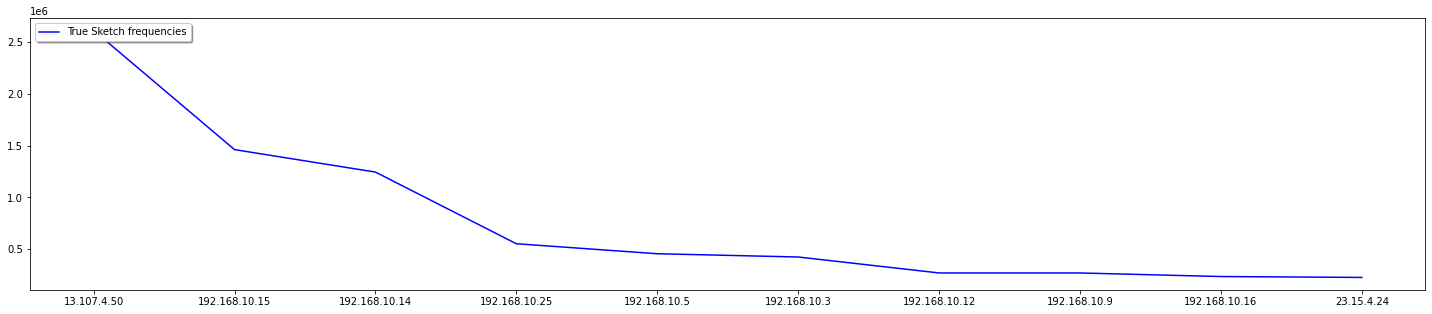

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(list(res_true_counterSketch.keys()), list(res_true_counterSketch.values()),'b',label='True Sketch frequencies')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

**Question 1:** We have chosen our parameters with a balance between running time and accuracy in mind. We wanted to achieve a good result while also ensuring that the algorithm is suitable for a real-time streaming environment. Adding more hash functions would result in a longer running time, while reducing the number of hash functions and space would negatively affect the accuracy of the results. Our belief is that in this type of problem, it is better to "pay" with space rather than time when the accuracy needs to be close to the true value and provide a good estimate.

in particular:
- The number of hash functions used in the algorithm is 20. A larger value of hash functions will result in a more accurate estimate of item frequencies, but will also increase the running time of the algorithm. In our case,we have  a relatively small number of hash functions, which may result in less accurate estimates but faster running time.
- The Space size which is the width of the multi-dimensional array used in the algorithm. A larger value of w will result in more buckets in the array, allowing for more accurate estimates of item frequencies, but will also increase the memory required to store the data structure. In our case, with w = 500,000, we have  a relatively large value for the width of the array, which may result in more accurate estimates but also requires more memory.


Overall, our choice of parameters is a balance between the running time and accuracy of the algorithm, as well as memory efficiency. It will bring a good estimate,  and it's more suitable for real-time streaming environment, but it might not be with the best accurate.

The algorithm that recognize elephnts flow is


**Question 2:**The algorithm that is more close in the avarege to the true value is CountSketch.
It's possible that in our implementation, the use of Morris counters with Count Sketch led to more accurate estimates in the average case, because it reduced the impact of hash collisions, which can cause errors in the estimates.

The algorithm that recognize rare flow is: